# Lecture 15 - K-Means Clustering

## K-Means Clustering Algorithm

K-Means algorithm is an iterative algorithm that tries to partition the dataset into $K$ pre-defined distinct non-overlapping subgroups (clusters) where each data point belongs to **only one group**. 

* K-Means Clustering is a centroid-based clustering.

* It tries to make the *inter-cluster* data points as similar as possible while also keeping the clusters as different (far) as possible.

* It assigns data points to a cluster such that the sum of the squared distance between the data points and the cluster's centroid (arithmetic mean of all data points that belong to that cluster) is at the minimum.

* The less variation we have within clusters, the more homogenous (similar) the data points are within the same cluster.

The **pseudo-code** is summarized as follows:

1. Specify number of clusters $K$

2. Initialize centroids by first shuffling the dataset amd then randomly selecting $K$ data points for the centroids without replacement. (There are different ways of initializing the centroids)

3. Keep iterating until there is no change to the centroids, i.e., assignment of data points to clusters isn't changing.
    * Compute the sum of the squared distance between data points and all centroids
    * Assign each data pint to the closest cluster (centroid)
    * Compute the centroids for the clusters by taking the average of all data points that belong to each cluster

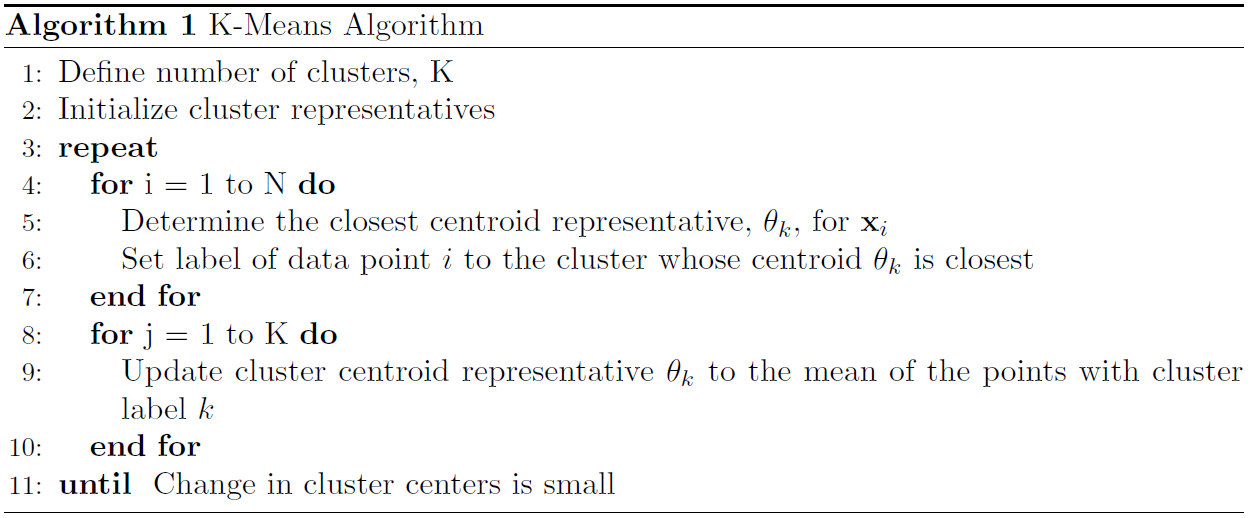

In [1]:
from IPython.display import Image
Image('figures/KMeans.png',width=800)

The K-Means algorithm uses **Expectation-Maximization (EM) as the optimization approach**:
* The E-Step assigns (hard) membership
* The M-step updates the representatives (centroids) for each cluster

As we learned before, optimization with EM is called **Alternating Optimization** and therefore the final solution will be **dependent** on the initialization (of cluster centroids). Therefore the final solution may not be the *optimal* solution.

* The objective function for the K-Means algorithm is:

\begin{align*}
J(\Theta,U) &= \sum_{i=1}^N\sum_{k=1}^K u_{ik} d^2\left(x_i, \theta_k\right)\\
&= \sum_{i=1}^N\sum_{k=1}^K u_{ik} \Vert x_i - \theta_k\Vert_2^2\\
\text{ such that } & u_{ik}\in\{0,1\}\text{ and }\sum_{k=1}^K u_{ik} = 1
\end{align*}

where $u_{ij}$ are cluster assignments, $\theta_j$ is the $j^{th}$ cluster representative and $d\left(x_i,\theta_k\right)$ is the distance between data point $x_i$ and cluster centroid $\theta_k$.

* In K-Means, we want to optimize:

\begin{align*}
\arg_{\Theta,U}\min J(\Theta,U)
\end{align*}

* If the **Euclidean distance** metric is used, does the K-means algorithm make any assumptions on cluster shape?
* Given a data set with an unknown number of clusters, can you come up with a strategy for determining the *right* number of clusters?
* Can we use other distance metrics in objective function $J(\Theta,U)$?

___

## Optimization of K-Means

In optimizing the cost function $J(\Theta,U)$, we want to find the best set of parameters $\{\Theta, U\}$ that minimize it.

**<font color='blue'>E-step</font>**
\begin{align*}
\frac{\partial J(\Theta,U)}{\partial u_{ik}} &= 0\\
\sum_{i=1} \Vert x_i - \theta_k\Vert_2^2 &= 0\\
\Rightarrow u_{ik} &= \begin{cases} 1 & \text{if } k=\arg\min_k \Vert x_i - \theta_k\Vert_2^2 \\ 0 & \text{otherwise}  \end{cases}
\end{align*}

* In other words, assign the data point $x_i$ to the closest cluster judged by its sum of squared distance from the cluster's centroid.

**<font color='blue'>M-step</font>**

\begin{align*}
\frac{\partial J(\Theta,U)}{\partial \Theta} &= 0\\
-2 \sum_{i=1}^N u_{ik} \left(x_i-\theta_k\right) &= 0\\
\sum_{i=1}^N u_{ik}x_i = \sum_{i=1}^N u_{ik}\theta_k &=0 \\
\sum_{i=1}^N u_{ik}x_i = \theta_k\sum_{i=1}^N u_{ik} &=0 \\
\theta_k = \frac{\sum_{i=1}^N u_{ik}x_i}{\sum_{i=1}^N u_{ik}} \\
\theta_k = \frac{\sum_{i=1}^N u_{ik}x_i}{N_k} \\
\theta_k = \frac{\sum_{x_i\in C_k} x_i}{N_k} \\
\end{align*}

where $N_k = \sum_{i=1}^N u_{ik}$ is the number of all data points assigned to cluster $C_k$, and $\sum_{x_i\in C_k} x_i=\sum_{i=1}^N u_{ik}x_i$ is the sum of data points that are assigned to cluster $C_k$.

* So the new cluster centroid is nothing but the **average** of all data points assigned to that cluster.

___

### Observations

1. Since K-Means uses distance-based measurements to determine the *similarity* between data points, it's recommended to **scale the data** since almost always the features in any data set would have different units of measurements (e.g. age vs income).

2. Given K-Means Alternating Optimization approach, different initializations may lead to different clusters, as K-Means algorithm may be stuck in a *local optima* and not converge to the *global optima*. Therefore, it's recommended to run the algorithm using different initializations of centroids and pick the results of the run that yielded the lower sum of squared distance.

3. One of the convergence criteria is to check whether the assignment of data points has not changed from one iteration to the next. This criteria of "assignment of points not changing" is the same as observing no change in the *within-cluster variation*:

\begin{align*}
\frac{1}{N_k}\sum_{i\in c_k} \Vert x_i - \theta_k\Vert_2^2
\end{align*}

___

## K-Means Applications

K-Means is a very popular algorithm and is commonly used in a variety of applications, such as: market segmentation, document clustering, image segmentation, image compression, etc.

The *goal* usually when we undergo a cluster analysis is either:

1. Get a meaningful intuition of the structure of the data we are dealing with.

2. Cluster-then-predict where different models will be built for different subgroups. An example of that is clustering patients into different subgroups (based on some feature map) and build a model for each subgroup to predict the probability of the risk of having a heart attack.

Let's take a look at two case applications for K-Means: Image Compression and Data Segmentation.

### Example: K-Means as Data Segmentation

In [1]:
from scipy.spatial.distance import cdist
from numpy.random import permutation
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

In [3]:
def KMeans(X, K, MaxIter = 10_000, Thresh = 1e-5, metric='Euclidean', Visualization = True):
    '''This function implements K-Means algorithm. 
    Where the data X will be partitioned into K clusters.
    Data matrix X is of size NxD, where N is the number of points and D the dimension of the data.'''

    #Initialize Cluster Centers by drawing Randomly from Data (can use other
    # methods for initialization...)
    N       = X.shape[0] #number of data points
    rp      = np.random.permutation(N); #random permutation of numbers 1:N
    centers = X[rp[0:K],:]; #select first K data points sorted according to rp
    
    if Visualization:
        plt.subplot(1,2,1)
        plt.scatter(X[:,0],X[:,1],c='b')
        plt.plot(centers[:,0],centers[:,1],'xr',markersize=20)
        plt.title('Randomly select K='+str(K)+' data points as Centroids')
        plt.show()
    
    diff    = np.inf;
    iteration    = 0;
    while((diff > Thresh) & (iteration < MaxIter)):
        
        # Compute distances of every point to every centroid
        D   = cdist(X, centers, metric=metric) # N-by-K matrix
        
        #Assign data to closest cluster representative (using Euclidean distance)
        L   = np.argmin(D, axis=1) # for every row, find the index of the column with the smallest distance
        # N-by-1 vector with labels

        # Visualization
        if Visualization:
            fig = plt.figure(figsize=(10,5))
            plt.subplot(1,2,1)
            plt.scatter(X[:,0],X[:,1],c=L)
            plt.plot(centers[:,0],centers[:,1],'xr',markersize=20)
            plt.title('Membership Assignment')
            
        #Update cluster centers
        centersPrev = centers.copy()
        for i in range(K):
            centers[i,:] = np.mean(X[L==i,:], axis=0)

        # Visualization
        if Visualization:
            plt.subplot(1,2,2)
            plt.scatter(X[:,0],X[:,1],c=L)            
            plt.plot(centers[:,0],centers[:,1],'xr',markersize=20)
            plt.title('Update Cluster Centroids')
        
        #Update diff & iteration count for stopping criteria
        diff = np.linalg.norm(centersPrev - centers)
        iteration = iteration+1
    return centers, L

# Plotting function for synthetically generated data
def Plotting(X, true_labels, L, name):
    fig = plt.figure(figsize=(12,4))
    if len(true_labels)>0:
        fig.add_subplot(1,2,1)
        plt.scatter(X[:,0],X[:,1],c=true_labels)
        plt.title(name)
    else:
        fig.add_subplot(1,2,1)
        plt.scatter(X[:,0],X[:,1],c='b')
        plt.title(name)
    fig.add_subplot(1,2,2)
    plt.scatter(X[:, 0], X[:, 1], c=L)
    plt.title("K-Means Clustering Results")

In [25]:
from sklearn import datasets

# Create synthetically generate data
n_samples = 1500
X1, T1 = datasets.make_blobs(n_samples=n_samples,centers=3,cluster_std=1)               # Blobs data
X2, T2 = datasets.make_blobs(n_samples=n_samples,cluster_std=[1.0, 2.5, 0.5],centers=3) # Different Variance Blobs data
X3, T3 = datasets.make_moons(n_samples=n_samples, noise=.05)                            # Moons data
X4, T4 = datasets.make_circles(n_samples, noise=.05, factor=0.5)                        # Circles data
X5     = np.dot(X1, [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]])             # Anisotropicly distributed data
X6     = np.vstack((X1[T1 == 0][:500], X1[T1 == 1][:100], X1[T1 == 2][:10]))            # Unevenly sized Blobs data
T6     = np.hstack((np.zeros(500),np.ones(100),2*np.ones(10)))

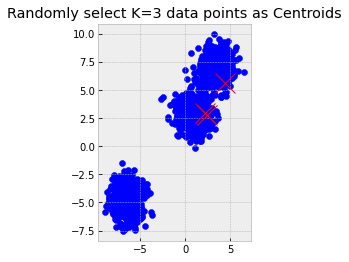

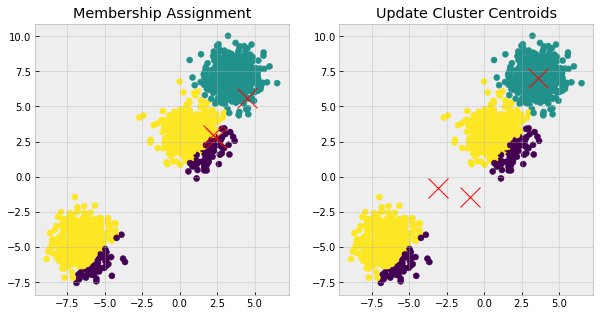

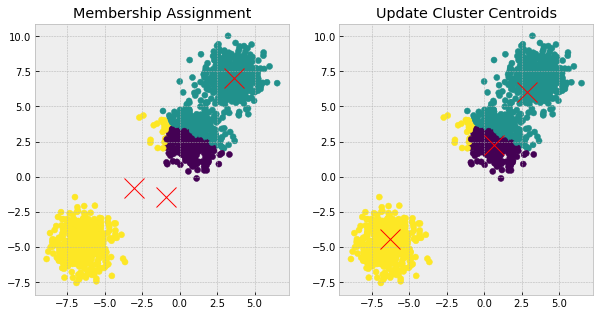

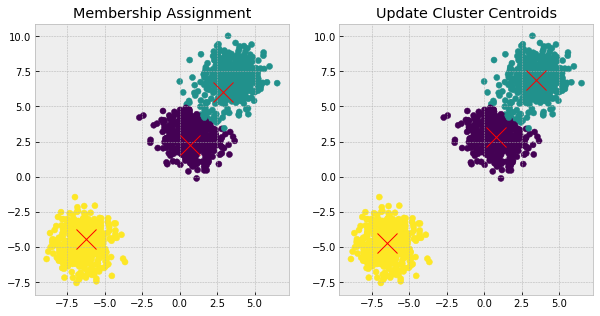

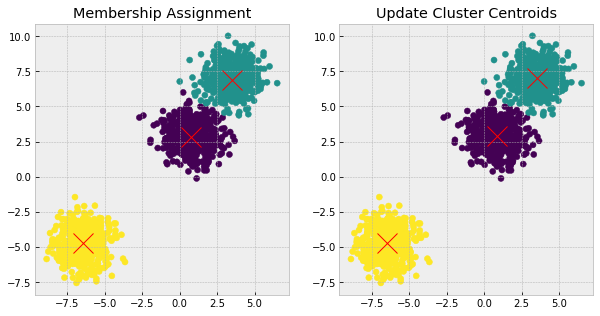

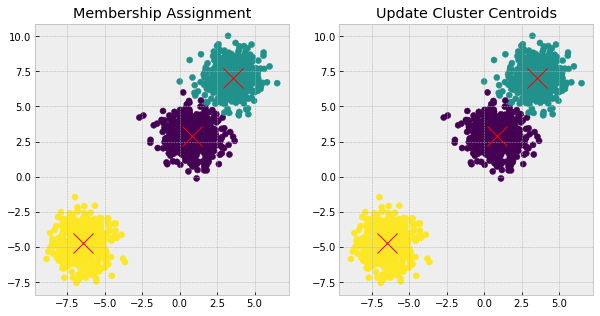

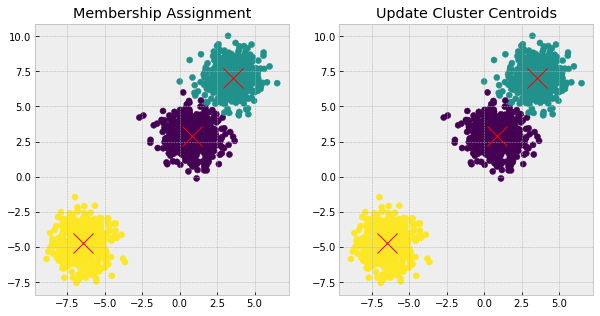

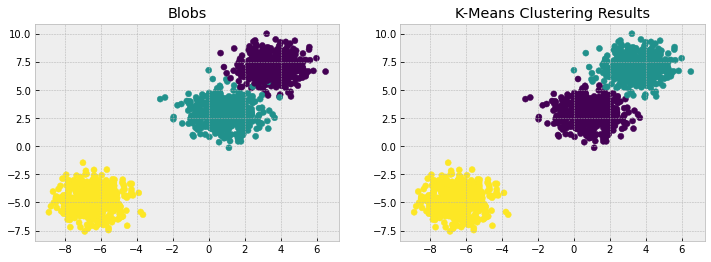

In [5]:
NoClusters = 3
C1, L1 = KMeans(X1, NoClusters, Visualization = True)
Plotting(X1, T1, L1, 'Blobs')

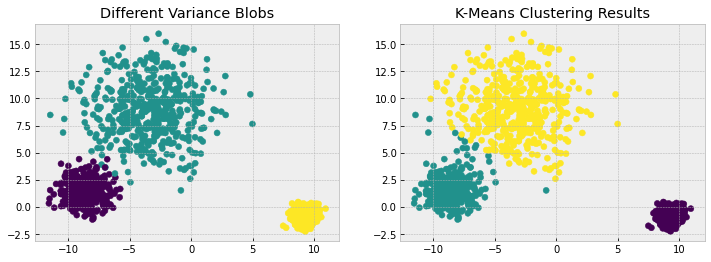

In [14]:
NoClusters = 3
C2, L2 = KMeans(X2, NoClusters, Visualization = False)
Plotting(X2, T2, L2, 'Different Variance Blobs')

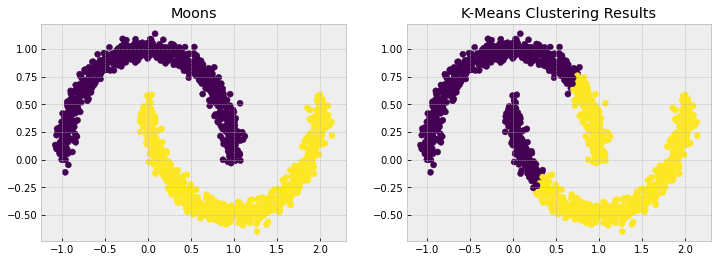

In [8]:
NoClusters = 2
C3, L3 = KMeans(X3, NoClusters, Visualization = False)
Plotting(X3, T3, L3, 'Moons')

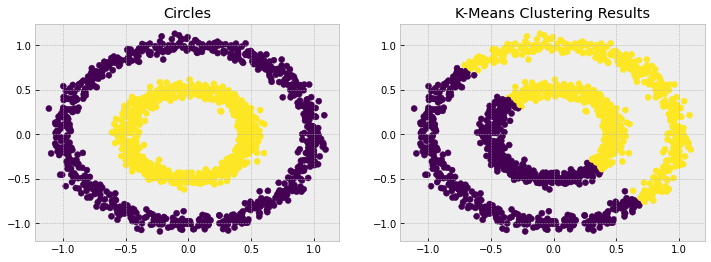

In [15]:
NoClusters = 2
C4, L4 = KMeans(X4, NoClusters, Visualization = False)
Plotting(X4, T4, L4, 'Circles')

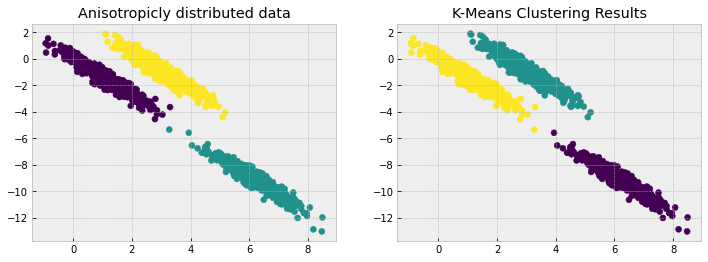

In [22]:
NoClusters = 3
C5, L5 = KMeans(X5, NoClusters, metric='mahalanobis', Visualization = False)
Plotting(X5, T1, L5, 'Anisotropicly distributed data')

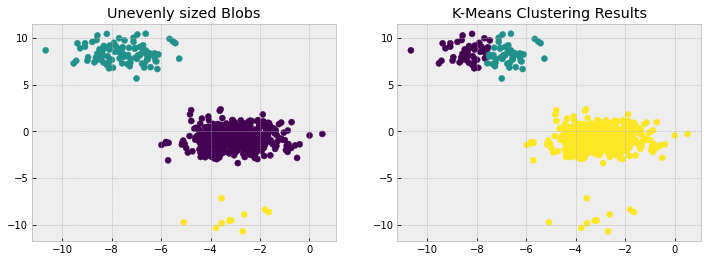

In [26]:
NoClusters = 3
C6, L6 = KMeans(X6, NoClusters, Visualization = False)
Plotting(X6, T6, L6, 'Unevenly sized Blobs')

___

### Example: K-Means as Image Compression

*Example and code from book ["Data Science Handbook" by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html)*

One interesting application of clustering is in color compression within images. For example, imagine you have an image with millions of colors. In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

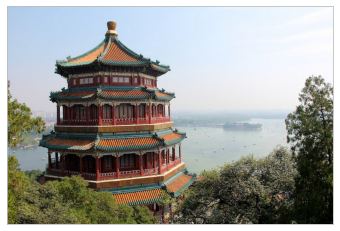

In [27]:
from sklearn.datasets import load_sample_image

image = load_sample_image('china.jpg')
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(image);

The image itself is stored in a three-dimensional array of size (height, width, RGB), containing red/blue/green contributions as integers from 0 to 255:

In [28]:
image.shape

(427, 640, 3)

One way we can view this set of pixels is as a cloud of points in a three-dimensional color space. We will reshape the data to $[$n_samples $\times$ n_features$]$, and rescale the colors so that they lie between 0 and 1:

In [29]:
# min-max scaling
data = image / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

We can visualize these pixels in this color space, using a subset of 10,000 pixels for efficiency:

In [30]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

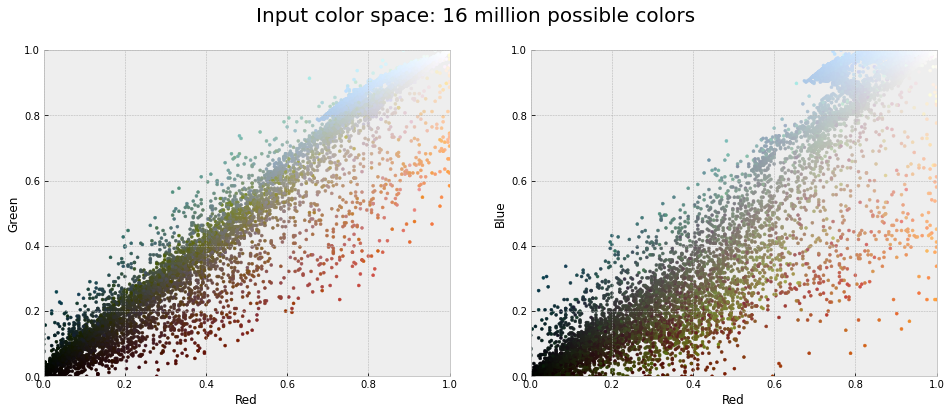

In [31]:
plot_pixels(data, title='Input color space: 16 million possible colors')

Now let's reduce these 16 million colors to just 16 colors, using K-Means clustering across the pixel space.

In [ ]:
from sklearn.cluster import KMeans as KMeans_sklearn

kmeans = KMeans_sklearn(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors, title="Reduced color space: 16 colors")

The result is a re-coloring of the original pixels, where each pixel is assigned the color of its closest cluster center. Plotting these new colors in the image space rather than the pixel space shows us the effect of this:

In [ ]:
image_recolored = new_colors.reshape(image.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(image)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(image_recolored)
ax[1].set_title('16-color Image', size=16);

Some detail is certainly lost in the rightmost panel, but the overall image is still easily recognizable. This image on the right achieves a compression factor of around 1 million! While this is an interesting application of k-means, there are certainly better ways to compress information in images. But the example shows the power of thinking outside of the box with unsupervised methods like k-means.

___